In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import matplotlib.pyplot as plt

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Assuming each folder contains the same number of corresponding images
        self.image_names = os.listdir(os.path.join(root_dir, "gaussian"))  

    def __len__(self):
        # Each clean image corresponds to 4 noisy images (gaussian, salt-pepper, poisson, speckle)
        return len(self.image_names)  

    def __getitem__(self, idx):
        images = []
        for noise_type in ["gaussian", "salt-pepper", "poisson", "speckle"]:
            img_path = os.path.join(self.root_dir, noise_type, self.image_names[idx])
            image = read_image(img_path).float() / 255.0  # Normalize to [0, 1]
            if self.transform:
                image = self.transform(image)
            images.append(image)

        # Load the corresponding clean image
        clean_img_path = os.path.join(self.root_dir, "clean", self.image_names[idx])
        clean_image = read_image(clean_img_path).float() / 255.0  # Normalize to [0, 1]
        if self.transform:
            clean_image = self.transform(clean_image)

        return torch.stack(images), clean_image

In [4]:
dataset = CustomImageDataset(root_dir="../data/div2k-denoise")

In [5]:
# DataLoader to handle batching
def custom_collate_fn(batch):
    noisy_batch = [item[0] for item in batch]
    clean_batch = [item[1] for item in batch]
    
    noisy_batch = torch.cat(noisy_batch, dim=0)
    
    clean_batch = torch.stack(clean_batch, dim=0)
    clean_batch = clean_batch.repeat(1, 4, 1, 1)
    clean_batch = clean_batch.reshape(clean_batch.shape[0]*clean_batch.shape[1],1,clean_batch.shape[2], clean_batch.shape[3])
    
    
    return noisy_batch, clean_batch  

data_loader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)

In [6]:

def display_grayscale_tensor(tensor):

    if tensor.dim() == 3 and tensor.shape[0] == 1:
        # Remove the channel dimension and convert to numpy for display
        image = tensor.squeeze().numpy()
    elif tensor.dim() == 2:
        image = tensor.numpy()
    else:
        raise ValueError("Tensor must be of shape (1, H, W) or (H, W)")

    plt.imshow(image, cmap='gray') 
    plt.axis('off') 
    plt.show()

In [7]:
# for noisy_batch, clean_batch in data_loader:
#     
#     print(noisy_batch.shape)
#     print(clean_batch.shape)
#     
#     for noisy_image in noisy_batch:
#         display_grayscale_tensor(noisy_image)
#     for clean_image in clean_batch:
#         display_grayscale_tensor(clean_image)
#     break

In [8]:
import gc

torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()
gc.collect()

35

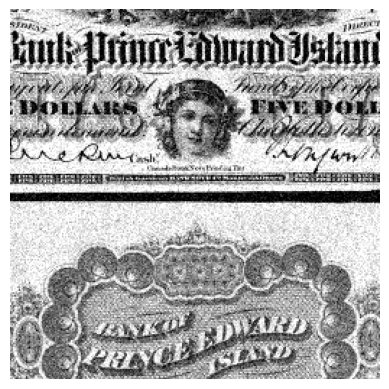

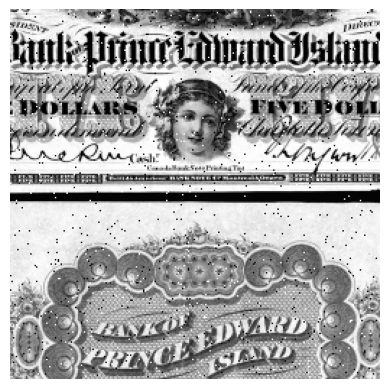

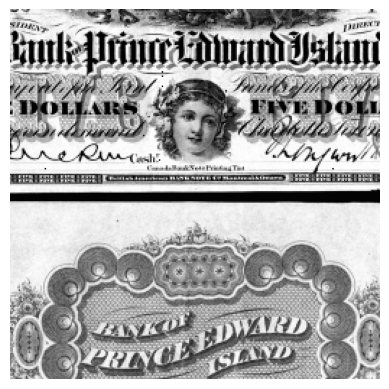

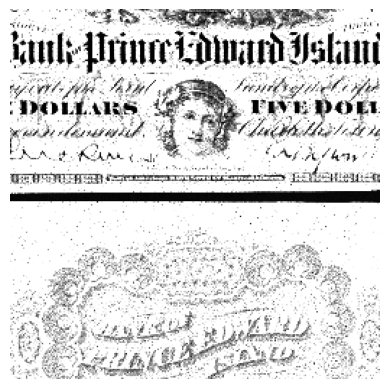

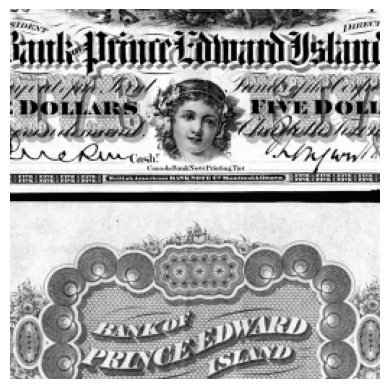

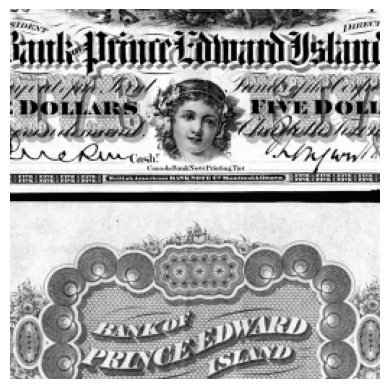

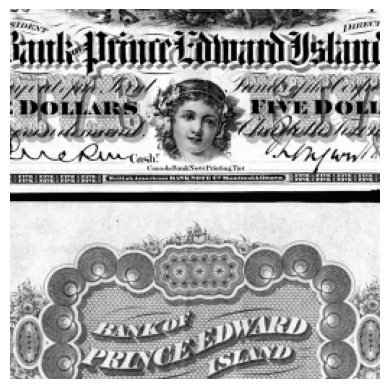

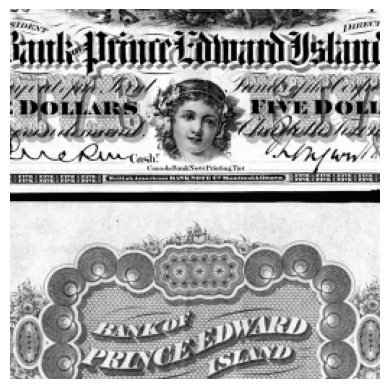

KeyboardInterrupt: 

In [10]:
import torch.nn as nn
import torch.optim as optim

from models.residualdenseunet import RDUNet

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = RDUNet(channels=64, base_filters=64).to(device)  # Adjust the parameters as needed

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 25  # Define the number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    batch_count = 0
    for noisy_imgs, clean_imgs in data_loader:
        
        # display_grayscale_tensor(noisy_imgs[4])
        # display_grayscale_tensor(noisy_imgs[5])
        # display_grayscale_tensor(noisy_imgs[6])
        # display_grayscale_tensor(noisy_imgs[7])
        # 
        # display_grayscale_tensor(clean_imgs[4])
        # display_grayscale_tensor(clean_imgs[5])
        # display_grayscale_tensor(clean_imgs[6])
        # display_grayscale_tensor(clean_imgs[7])
        
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(noisy_imgs)
        
        # Calculate loss
        loss = criterion(outputs, clean_imgs)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        batch_count += 1
        
        print("Processing Epoch:", epoch+1, "Batch:", batch_count, "Loss:", running_loss/batch_count)

    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(data_loader)}')
    
        # Save model and optimizer state
    state = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        # Include other states you need, e.g., scheduler
    }
    torch.save(state, f'../checkpoints/checkpoint_epoch_{epoch}.pth')
    
print('Finished Training')